In [1]:
from pychastic.problems.kp_4_27 import KloedenPlaten4_27
from pychastic.sde_solver import SDESolver
import pychastic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm


# Kloeden-Platen PC Exercise 9.3.2

In [76]:
a = 1.5
b = 1.0
problem = pychastic.sde_problem.SDEProblem(
  lambda x: a*x,
  lambda x: b*x,
  x0 = 1.0,
  tmax=1,
  exact_solution = lambda x0, t, w: x0*np.exp((a-b**2/2)*t+b*w)
)


solvers = [
  SDESolver(adaptive=False, scheme='euler'),
  #SDESolver(adaptive=False, scheme='milstein'),
]

dts = [2**-4, 2**-5, 2**-6, 2**-7]
n_rows = 10
n_wieners_per_cell = 25

results = np.zeros((len(solvers), len(dts), n_rows, n_wieners_per_cell), dtype=dict)  # solver x dt x wiener

for n_solver, solver in enumerate(solvers):
  for n_dt, dt in enumerate(dts):
    solver.dt = dt
    for n_row in range(n_rows):
      solutions = solver.solve_many(problem, n_trajectories=n_wieners_per_cell)
      results[n_solver, n_dt, n_row] = solutions

100%|██████████| 25/25 [00:00<00:00, 29.69it/s]


In [77]:
s = results.shape
results_flat = results.flatten()
def f(sol):
  x = sol['solution_values'][-1]
  x_exact = problem.exact_solution(problem.x0, sol['time_values'][-1], sol['wiener_values'][-1])
  e = abs(x - x_exact)
  return e
errors = np.array([f(x) for x in results_flat]).reshape(s)
errors.shape

(1, 4, 10, 25)

In [78]:
tabelka = errors[0, :, :, :].mean(axis=-1).T  # table 9.3.2
tabelka

array([[0.56518399, 0.65950864, 0.19690504, 0.20958223],
       [0.6772475 , 1.19819114, 0.18282874, 0.18074911],
       [0.84024718, 0.31052947, 0.3657544 , 0.26101287],
       [0.50064731, 0.61189162, 0.26361279, 0.20274393],
       [0.66442902, 0.44949152, 0.24668586, 0.14517243],
       [0.29288093, 0.22092658, 0.27674665, 0.20432677],
       [0.54417726, 0.28192614, 0.29337388, 0.09935175],
       [0.86231286, 0.27727435, 0.15704454, 0.29025942],
       [0.92075485, 0.42518642, 0.17424531, 0.17062894],
       [0.4284626 , 0.2898782 , 0.36098522, 0.20372754]])

# Exercise 9.3.3

In [102]:
a = 1.5
b = 0.1
problem = pychastic.sde_problem.SDEProblem(
  lambda x: a*x,
  lambda x: b*x,
  x0 = 1.0,
  tmax=1,
  exact_solution = lambda x0, t, w: x0*np.exp((a-b**2/2)*t+b*w)
)


solvers = [
  SDESolver(adaptive=False, scheme='euler'),
  #SDESolver(adaptive=False, scheme='milstein'),
]

dts = [2**-4]
n_rows = 100
n_wieners_per_cell = 100

results = np.zeros((len(solvers), len(dts), n_rows, n_wieners_per_cell), dtype=dict)  # solver x dt x wiener

for n_solver, solver in enumerate(solvers):
  for n_dt, dt in enumerate(dts):
    solver.dt = dt
    solutions = solver.solve_many(problem, n_trajectories=n_wieners_per_cell*n_rows)
    results[n_solver, n_dt] = np.array(solutions).reshape((n_rows, n_wieners_per_cell))  # n_rows x n_winers_per_cell

100%|██████████| 10000/10000 [00:40<00:00, 246.06it/s]


In [103]:
s = results.shape
results_flat = results.flatten()
def f(sol):
  x = sol['solution_values'][-1]
  x_exact = problem.exact_solution(problem.x0, sol['time_values'][-1], sol['wiener_values'][-1])
  assert np.isclose(sol['time_values'][-1], problem.tmax)
  e = abs(x - x_exact)
  return e
errors = np.array([f(x) for x in results_flat]).reshape(s)
errors.shape

(1, 1, 100, 100)

<ErrorbarContainer object of 3 artists>

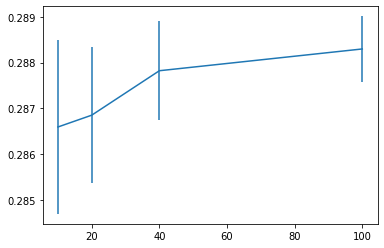

In [104]:
column = errors[0,0].mean(axis=-1)
means = [
  column[:10].mean(),
  column[:20].mean(),
  column[:40].mean(),
  column[:100].mean(),
]

stds = [
  column[:10].std()/np.sqrt(10),
  column[:20].std()/np.sqrt(20),
  column[:40].std()/np.sqrt(40),
  column[:100].std()/np.sqrt(100),
]

plt.errorbar([10, 20, 40, 100], means, stds)

# Exercise 9.3.4 / 10.3.2

In [5]:
%%time

a = 1.5
b = 1.0#0.1
problem = pychastic.sde_problem.SDEProblem(
  lambda x: a*x,
  lambda x: b*x,
  x0 = 1.0,
  tmax=1,
  exact_solution = lambda x0, t, w: x0*np.exp((a-b**2/2)*t+b*w)
)

solvers = [
  SDESolver(adaptive=False, scheme='euler'),
  SDESolver(adaptive=False, scheme='milstein'),
  SDESolver(adaptive=False, scheme='wagner_platen'),
]

#dts = [2**-2, 2**-3, 2**-4, 2**-5, 2**-6]
dts = [2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7]
n_rows = 20
n_wieners_per_cell = 50#100

results = np.zeros((len(solvers), len(dts), n_rows, n_wieners_per_cell), dtype=dict)  # solver x dt x wiener
#wieners = [pychastic.wiener.Wiener(seed=i) for i in range(n_wieners_per_cell*n_rows)]  ##

for n_solver, solver in enumerate(solvers):
  for n_dt, dt in enumerate(dts):
    solver.dt = dt
    solutions = solver.solve_many(problem, n_trajectories=n_wieners_per_cell*n_rows)
    #solutions = solver.solve_many(problem, wieners=wieners)
    results[n_solver, n_dt] = np.array(solutions).reshape((n_rows, n_wieners_per_cell))  # n_rows x n_winers_per_cell

100%|██████████| 1000/1000 [00:31<00:00, 32.18it/s]

CPU times: user 3min 37s, sys: 1min 13s, total: 4min 50s
Wall time: 3min 1s


In [3]:
s = results.shape
results_flat = results.flatten()
def f(sol):
  x = sol['solution_values'][-1]
  x_exact = problem.exact_solution(problem.x0, sol['time_values'][-1], sol['wiener_values'][-1])
  assert np.isclose(sol['time_values'][-1], problem.tmax)
  e = abs(x - x_exact)
  return e
errors = np.array([f(x) for x in results_flat]).reshape(s)
errors.shape

(3, 6, 20, 20)

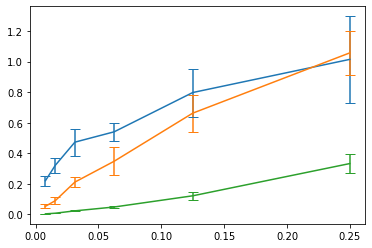

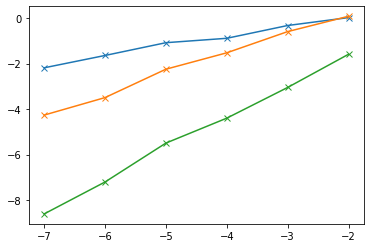

In [4]:
table_euler = errors[0].mean(axis=-1).T
table_milstein = errors[1].mean(axis=-1).T
table_wp = errors[2].mean(axis=-1).T

mu_euler = table_euler.mean(axis=0)
sd_euler = table_euler.std(axis=0)/np.sqrt(n_wieners_per_cell)
mu_milstein = table_milstein.mean(axis=0)
sd_milstein = table_milstein.std(axis=0)/np.sqrt(n_wieners_per_cell)
mu_wp = table_wp.mean(axis=0)
sd_wp = table_wp.std(axis=0)/np.sqrt(n_wieners_per_cell)

plt.errorbar(dts, mu_euler, 2*sd_euler, capsize=5)
plt.errorbar(dts, mu_milstein, 2*sd_milstein, capsize=5)
plt.errorbar(dts, mu_wp, 2*sd_wp, capsize=5)
#plt.xlim(0, 0.02)
#plt.ylim(0, 0.1)
plt.show()

plt.plot(np.log2(dts), np.log2(mu_euler), marker='x')
plt.plot(np.log2(dts), np.log2(mu_milstein), marker='x')
plt.plot(np.log2(dts), np.log2(mu_wp), marker='x')

In [10]:
solver = SDESolver(dt=2**-6)
solver.solve_many(problem, n_trajectories=1000);

100%|██████████| 1000/1000 [00:16<00:00, 62.44it/s]


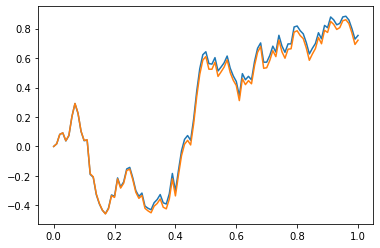

In [30]:
solution = results[0,0,0]
t = solution['time_values']
x = solution['solution_values']
w = solution['wiener_values']
x_exact = problem.exact_solution(problem.x0, t, w)
plt.plot(t, x)
plt.plot(t, x_exact)